# Example 1: Wasserstein distance estimation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/deel-torchlip/blob/master/docs/notebooks/wasserstein_toy.ipynb)

In this notebook we estimate the Wasserstein distance through its Kantorovich-Rubinstein
dual representation by using a 1-Lipschitz neural network.

## 1. Wasserstein distance

The Wasserstein distance measures the distance between two probability distributions.
The Wikipedia article gives a more intuitive definition:

> Intuitively, if each distribution is viewed as a unit amount of "dirt" piled on $M$,
> the metric is the minimum "cost" of turning one pile into the other, which is assumed
> to be the amount of dirt that needs to be moved times the mean distance it has to be
> moved. Because of this analogy, the metric is known in computer science as the earth
> mover's distance.

Mathematically it is defined as

$$
W_1(\mu,\nu) = \inf_{\pi \in \Pi(\mu,\nu)}\underset{x,z \sim \pi}{\mathbb{E}}\Vert{} \textbf{x}-\textbf{z} \Vert{}
$$

where $\Pi(\mu,\nu)$ is the set of all probability measures on $\Omega\times \Omega$
with marginals $\mu$ and $\nu$. In most case this equation is not tractable.


In [1]:
# Install the required library deel-torchlip (uncomment line below)
# %pip install -qqq deel-torchlip

## 2. Parameters input images

We illustrate this on a synthetic image dataset where the $W_1$ distance is known.

Our synthetic dataset contains images with black or white squares, allowing us to check
if the computed Wasserstein distance is correct. The two distributions are

- the set of black images (all 0),
- the set of images with a square on it (all 0, with a square of -1 or +1 in the
  middle).


In [2]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np

size = (64, 64)
frac = 0.3  # proportion of the center square


def generate_toy_images(shape: Tuple[int, int], frac: float = 0, value: float = 1):
    """
    Generates a single image.

    Args:
        shape: Shape of the output image.
        frac: Proportion of the center rectangle.
        value: Value assigned to the center rectangle.
    """
    img = np.zeros(shape)
    if frac == 0:
        return img

    frac = frac ** 0.5

    l = int(shape[0] * frac)
    ldec = (shape[0] - l) // 2
    w = int(shape[1] * frac)
    wdec = (shape[1] - w) // 2

    img[ldec : ldec + l, wdec : wdec + w] = value

    return img


def generator(batch_size: int, shape: Tuple[int, int], frac: float):
    """
    Creates an infinite generator that generates batch of images. Half of the batch
    comes from the first distribution (only black images), while the remaining half
    comes from the second distribution.

    Args:
        batch_size: Number of images in each batch.
        shape: Shape of the image.
        frac: Fraction of the square to set "white".

    Returns:
        An infinite generator that yield batch of the given size.
    """

    pwhite = generate_toy_images(shape, frac=frac, value=1)
    nwhite = generate_toy_images(shape, frac=frac, value=-1)

    nblack = batch_size // 2
    nsquares = batch_size - nblack
    npwhite = nsquares // 2
    nnwhite = nsquares - npwhite

    batch_x = np.concatenate(
        (
            np.zeros((nblack,) + shape),
            np.repeat(pwhite[None, ...], npwhite, axis=0),
            np.repeat(nwhite[None, ...], nnwhite, axis=0),
        ),
        axis=0,
    )
    batch_y = np.concatenate((np.zeros((nblack, 1)), np.ones((nsquares, 1))), axis=0)

    while True:
        yield batch_x, batch_y


def display_image(ax, image, title: str = ""):
    ax.imshow(image, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

We consider images of size 64x64, and an inner square that covers about 30% of the image. 
We can manually compute the $W_1$ distance between the two sets.

L2-Norm, black vs. 'negative' white -> 35.0
L2-Norm, black vs. 'positive' white -> 35.0


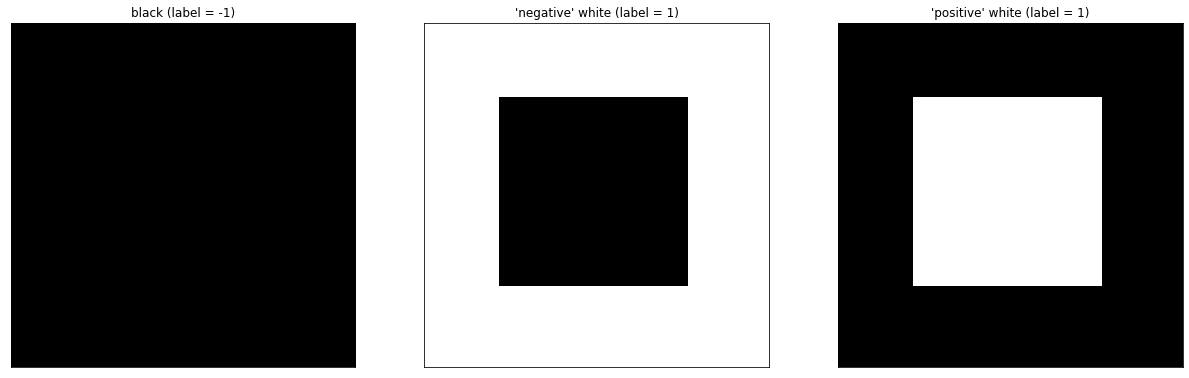

In [3]:
img1 = generate_toy_images(size, 0)
img2 = generate_toy_images(size, frac, value=-1)
img3 = generate_toy_images(size, frac, value=1)

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

display_image(axs[0], img1, "black (label = -1)")
display_image(axs[1], img2, "'negative' white (label = 1)")
display_image(axs[2], img3, "'positive' white (label = 1)")

print("L2-Norm, black vs. 'negative' white -> {}".format(np.linalg.norm(img2 - img1)))
print("L2-Norm, black vs. 'positive' white -> {}".format(np.linalg.norm(img3 - img1)))

As we can see, the distance between the fully black image and any of the two images with an inner square is $35$, and these are the only images in our distributions, the $W_1$ distance between the two distances is also $35$.

## 3. Kantorovich-Rubinstein dual formulation

The Kantorovich-Rubinstein (KR) dual formulation of the Wasserstein distance is

$$ W_1(\mu, \nu) = \sup_{f \in Lip_1(\Omega)} \underset{\textbf{x} \sim \mu}{\mathbb{E}}
\left[f(\textbf{x} )\right] -\underset{\textbf{x} \sim \nu}{\mathbb{E}}
\left[f(\textbf{x} )\right]. $$

This states the problem as an optimization problem over the space of 1-Lipschitz
functions. We can estimate this by optimizing over the space of 1-Lipschitz neural
networks.

- [1] C. Anil, J. Lucas, et R. Grosse, "Sorting out Lipschitz function approximation",
  arXiv:1811.05381, nov. 2018.


### 3.1. Building a 1-Lipschitz model

In this section, we use the `deel.torchlip` (short `torchlip`) to build a 1-Lipschitz
network. The `torchlip` library is the PyTorch equivalent of
[`deel-lip`](https://github.com/deel-ai/deel-lip). In this example, we use two
1-Lipschitz layers and a special activation function:

- `SpectralLinear` uses spectral normalization to force the maximum singular value of
  the weight matrix to be one, followed by Bjorck normalization to force all singular
  values to be 1. After convergence, all singular values are equal to 1 and the linear
  operation is 1-Lipschitz. The `SpectralLinear` class also uses orthogonal
  initialization for the weight (see `torch.init.orthogonal_`).
- `FrobeniusLinear` simply divides the weight matrix by its Frobenius norm. We only use
  it for the last layer because this layer has a single output. Similar to
  `SpectralLinear`, the weights are initialized using orthogonal initialization.
- We use `FullSort` activation, which is a 1-Lipschitz activation.


In [4]:
import torch
from deel import torchlip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wass = torchlip.Sequential(
    torch.nn.Flatten(),
    torchlip.SpectralLinear(np.prod(size), 128),
    torchlip.FullSort(),
    torchlip.SpectralLinear(128, 64),
    torchlip.FullSort(),
    torchlip.SpectralLinear(64, 32),
    torchlip.FullSort(),
    torchlip.FrobeniusLinear(32, 1),
).to(device)

wass

  from .autonotebook import tqdm as notebook_tqdm


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): ParametrizedSpectralLinear(
    in_features=4096, out_features=128, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _SpectralNorm()
        (1): _BjorckNorm()
      )
    )
  )
  (2): FullSort()
  (3): ParametrizedSpectralLinear(
    in_features=128, out_features=64, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _SpectralNorm()
        (1): _BjorckNorm()
      )
    )
  )
  (4): FullSort()
  (5): ParametrizedSpectralLinear(
    in_features=64, out_features=32, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _SpectralNorm()
        (1): _BjorckNorm()
      )
    )
  )
  (6): FullSort()
  (7): ParametrizedFrobeniusLinear(
    in_features=32, out_features=1, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _FrobeniusNorm()
      )
    )
  )


### 3.2. Training a 1-Lipschitz network with KR loss

We now train this neural network using the Kantorovich-Rubinstein formulation for the
Wasserstein distance.


In [5]:
from deel.torchlip import KRLoss
from tqdm import trange

batch_size = 16
n_epochs = 10
steps_per_epoch = 256

# Create the image generator:
g = generator(batch_size, size, frac)

kr_loss = KRLoss()
optimizer = torch.optim.Adam(lr=0.01, params=wass.parameters())

n_steps = steps_per_epoch // batch_size

for epoch in range(n_epochs):

    tsteps = trange(n_steps, desc=f"Epoch {epoch + 1}/{n_epochs}")
    for _ in tsteps:
        data, target = next(g)
        data, target = (
            torch.tensor(data).float().to(device),
            torch.tensor(target).float().to(device),
        )
        optimizer.zero_grad()
        output = wass(data)
        loss = kr_loss(output, target)
        loss.backward()
        optimizer.step()
        tsteps.set_postfix({"loss": "{:.6f}".format(loss)})


Epoch 10/10: 100%|██████████| 16/16 [00:00<00:00, 103.46it/s, loss=-34.995232]


As we can see the loss converges to the value $35$ which is the $W_1$ distance between
the two distributions (with and without squares).


<div class="alert alert-block alert-danger"></div>